In [15]:
import statsmodels.api as sm
import seaborn as sns
import python_lib.models as models
import python_lib.graph_gen as graph_gen
import sys
import networkx as nx
import numpy as np
import random
from collections import defaultdict
import torch
import math
import importlib
import pandas as pd
# torch.set_num_threads(1)

sys.path.insert(0, '../../')
#from python_lib import solvers


In [16]:
%matplotlib inline


In [17]:
name = ["J", "J_not", "J_net", "samples"]


In [18]:
data = np.load("MC_data/data.npz")


In [19]:
dat_dict = dict(zip(name, data.values()))


In [20]:
J = dat_dict["J"]
J_not = dat_dict["J_not"]
J_net = dat_dict["J_net"]
samples = dat_dict["samples"]


In [21]:
N = J.shape[0]

torch.triu_indices(N, N, offset=1)


tensor([[ 0,  0,  0,  ..., 97, 97, 98],
        [ 1,  2,  3,  ..., 98, 99, 99]])

In [22]:
idx = torch.tril_indices(N, N, offset=-1).T
JJ = np.abs(J[idx[:, 0], idx[:, 1]])
JJ_not = np.abs(J_not[idx[:, 0], idx[:, 1]])
JJ_net = np.abs(J_net[idx[:, 0], idx[:, 1]])


In [23]:

model = sm.OLS(JJ_net, sm.add_constant(JJ))
results = model.fit()

print(results.params)
# const        10.603498 <- intercept
# education     0.594859 <- slope
# dtype: float64

print(results.summary())

r = np.sqrt(results.rsquared)
print('Pearson correlation:', r)


[0.13941854 2.76877498]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     3499.
Date:                Fri, 08 Sep 2023   Prob (F-statistic):               0.00
Time:                        10:36:36   Log-Likelihood:                 1108.0
No. Observations:                4950   AIC:                            -2212.
Df Residuals:                    4948   BIC:                            -2199.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1394      0

In [24]:
from scipy.stats import pearsonr

# JJ_net and JJ should be your data arrays
correlation, p_value = pearsonr(JJ_net, JJ)

print('Pearson correlation:', correlation)
print('p-value:', p_value)


Pearson correlation: 0.6436212940481505
p-value: 0.0


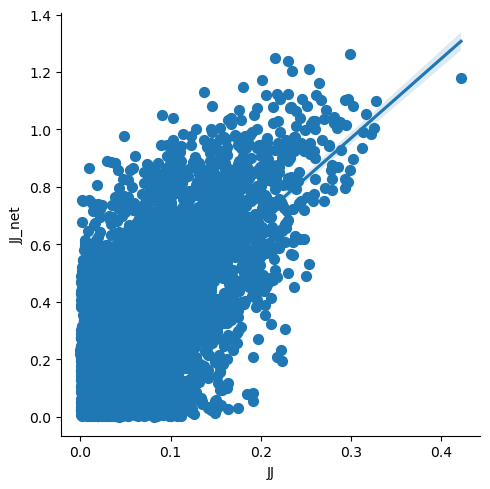

In [25]:
df_jj = pd.DataFrame({"JJ": JJ, "JJ_net": JJ_net})
sns.lmplot(x="JJ", y="JJ_net", data=df_jj, x_estimator=np.mean)


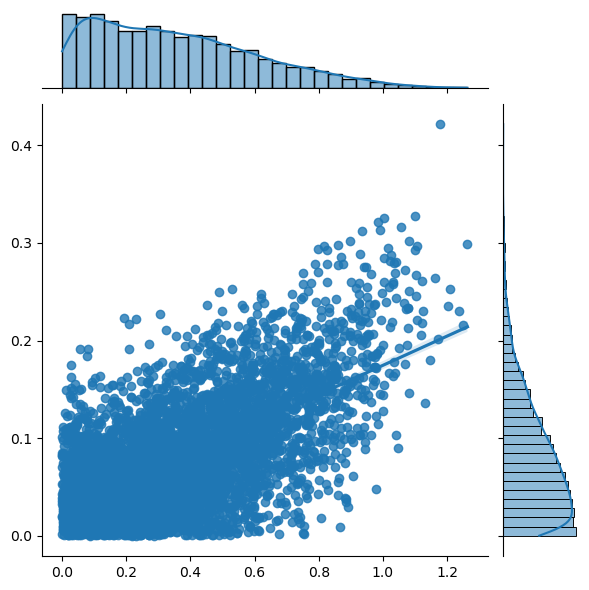

In [26]:
sns.jointplot(x=JJ_net, y=JJ, kind="reg")


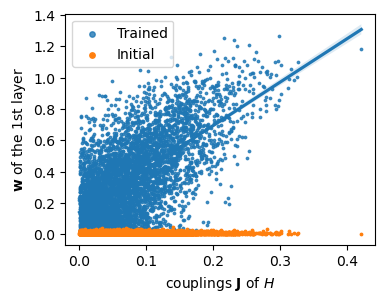

In [27]:
import matplotlib.pyplot as plt
import itertools
fig, ax = plt.subplots(figsize=(4, 3))
colors = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
sns.regplot(x=JJ, y=JJ_net, ax=ax, scatter_kws={
            "s": 3}, scatter=True, label="Trained")
next(colors)
ax.scatter(JJ, JJ_not, s=3, label="Initial", ls="None", c=next(colors))
#ax = sns.regplot(x=JJ, y=JJ_net, x_bins=15, ax = ax)
# ax.legend()
ax.set_ylabel("$\mathbf{w}$ of the 1st layer")
ax.set_xlabel(r"couplings $\mathbf{J}$ of $H$")

lgnd = plt.legend(loc="upper left", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [15]
lgnd.legendHandles[1]._sizes = [15]

plt.savefig("../tex/img/MC_img.pdf", bbox_inches='tight')
plt.show()


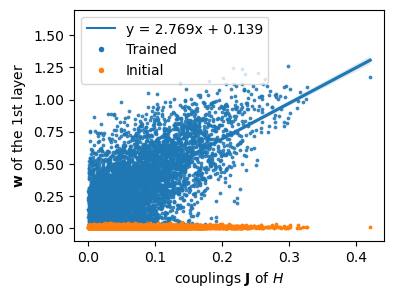

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(4, 3))

# Get the current color palette
colors = sns.color_palette()

# Regression plot with scatter
sns.regplot(x=JJ, y=JJ_net, ax=ax, scatter_kws={"s": 3, "color": colors[0]}, line_kws={
            "color": colors[0]}, color=colors[0], label="Trained")

# Scatter plot
ax.scatter(JJ, JJ_not, s=3, color=colors[1], label="Initial", ls="None")

# Linear regression
slope, intercept = np.polyfit(JJ, JJ_net, 1)

ax.set_ylabel("$\mathbf{w}$ of the 1st layer")
ax.set_xlabel(r"couplings $\mathbf{J}$ of $H$")

# Create custom legend
legend_elements = [

    Line2D([0], [0], marker='None', color=colors[0],
           label=f'y = {slope:.3f}x + {intercept:.3f}'),
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=colors[0], markersize=5, label='Trained'),
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=colors[1], markersize=5, label='Initial'),
]
ax.set_ylim(-0.1, 1.7)
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

#plt.savefig("../tex/comphys_rev/img/MC_img.pdf", bbox_inches='tight')
plt.show()
